# Data Exploration of MA High Schools and National Universities

In the education industry, high schools prepare students for the next chapter in his or her life. Aside from GPA, SAT scores assist in measuring learned skills, knowledge and prestige in institutions. Using student data from high schools in Massachusettes and various national universities, how well prepared are high school students in Massachuesettes for universities in United States. Furthermore, is Massachuesettes' Accountability and Assistance level a reliable indicator of education quality compared to universities in Massachuesettes?


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Import the first dataset (Massachusetts high school)
mshs=pd.read_csv('../data/external/MA_Public_Schools_2017.csv')

#Import the second dataset (University data)
univ=pd.read_json('../data/external/schoolInfo.json')

## Cleaning up datasets
The goal in mind requires few columns. After dropping unrelated columns, I remove the empty values on SAT scores and Accountability and Assistance Levels.

#### Massachusettes Data Set:
1. Drop all columns not related to SAT scores, schoool name, school state and zip location, school type (Private/Public), and PPI. These are the columns we desire to see correlation with university data
2. Since I only desire high schools, I view rows with 12th grade enrollment. Then drop this column. I do the same for SAT scores without dropping.
3. Lastly, I remove rows with empty values in Account/Assist levels.

#### University Data Set:
1. Drop all columns not regarding SAT scores, state location, and enrollment.  
2. Drop rows with empty values for SAT-avg 

In [2]:
#Cleaning MA high school data

#------------Dropping Columns------------
#Drop columns regarding MCAS scores
mshsFirst=mshs.iloc[:,0:31].copy()

mshsSecond=mshs.iloc[:,93:97].copy()

mshsLast=mshs.iloc[:,293:302].copy()

#also drop all demographics of students.
mshsdemo=mshs.iloc[:,51:53].copy()


#merge the tables
mshsFinal=mshsFirst.join(mshsdemo, how='outer')
mshsFinal=mshsFinal.join(mshsSecond, how='outer')
mshsFinal=mshsFinal.join(mshsLast, how='outer')

#Dropping additional columns based on name based on findings and reevaluations. 
#The additional dropping due to irrelevant information and not following certain exploratory paths.
#One example is using ZIP codes in MA to determine if certain areas present better education

mshsFinal=mshsFinal.drop(columns=['School Code','Function','Contact Name','Address 1','Address 2','Phone','Fax','Grade','PK_Enrollment','K_Enrollment', '1_Enrollment',
                                  '2_Enrollment','3_Enrollment','4_Enrollment','5_Enrollment','6_Enrollment',
                                  '7_Enrollment', '8_Enrollment','9_Enrollment','10_Enrollment','11_Enrollment',
                                  'Accountability and Assistance Description','District_Accountability and Assistance Level',
                                  'District_Accountability and Assistance Description','Progress and Performance Index (PPI) - High Needs Students',
                                  'District_Progress and Performance Index (PPI) - High Needs Students','District Name','District Code',
                                 'SP_Enrollment','School Type', 'Town','Average Class Size', 'Number of Students', 
                                  'SAT_Tests Taken','Average SAT_Writing','School Accountability Percentile (1-99)',
                                  'Progress and Performance Index (PPI) - All Students','District_Progress and Performance Index (PPI) - All Students',])


##Remove all non high schools or nonenrollment of seniors
mshsFinal=mshsFinal[mshsFinal['12_Enrollment'] > 0]

#Drop the column
mshsFinal=mshsFinal.drop(columns=['12_Enrollment'])

##Remove all rows without district performance progress
mshsFinal=mshsFinal.dropna(subset=['Accountability and Assistance Level'])
mshsFinal=mshsFinal[mshsFinal['Accountability and Assistance Level'] != 'Insufficient data' ]

#Remove all rows without average SAT reading and SAT Math
mshsFinal=mshsFinal[mshsFinal['Average SAT_Reading']>0]
mshsFinal=mshsFinal[mshsFinal['Average SAT_Math']>0]
##-----------------------------------------------------------------------------------------
#Cleaning up university data

#----------Dropping columns----------
#Not relevant
univ=univ.drop(columns=['primaryKey','act-avg','aliasNames','businessRepScore','sortName',
                        'primaryPhoto','primaryPhotoThumb','rankingType','rankingMaxPossibleScore',
                        'rankingDisplayName','rankingNoteText','rankingNoteCharacter','sortName',
                        'urlName','xwalkId','nonResponder','nonResponderText','rankingIsTied',
                        'rankingRankStatus','engineeringRepScore','isPublic','cost-after-aid', 
                        'hs-gpa-avg', 'overallRank','percent-receiving-aid', 'rankingDisplayRank', 
                        'rankingDisplayScore','rankingSortRank','tuition','city','region'])

#remove NaN entries in sat-avg
univ=univ.dropna(subset=['sat-avg'])

## Transforming Data
In order to merge the two datasets, tranformations must occur.

#### Massachusettes Data Set:
1. I altered the institutional control from a string (public/charter) to True for public and False for private entities. Since only public and charter schools existed in the data set, and charter schools are treated as public from the federal education department, all the values in this column are set to True.
2. I also altered the names of columns such that the merge of datasets match with the proper data.
3. For school types, to help distinguish between institutions, 'schoolType' is added and labelled high-school.
4. Lastly, I determined the average SAT based on high school and reading scores.

#### University Data Set:
1. Columns are renamed to match the MA data set in preparation for merge.

In [3]:
#----------Transforming High School Data----------
#Transform high school public to boolean
#The data on school type is public OR charter school.
#charter schools seen as public from federal education department
mshsFinal['Institutional Control']=True

#Change TOTAL Enrollment to Enrollment
mshsFinal.rename(columns={'TOTAL_Enrollment':'Enrollment'},inplace=True)

#Add column categorizing high schools vs universities (will help with merge)
mshsFinal.loc[:,'schoolType']=pd.Series('high-school', index=mshsFinal.index, dtype="category")

#Adding column and calculating average SAT scores
mshsFinal.loc[:,'sat-avg']=mshsFinal['Average SAT_Reading']+mshsFinal['Average SAT_Math']

#----------Transforming University Data----------
#Change column for university name, city, zip, enrollment, and private/public institution for merge
univ.rename(columns={'displayName':'School Name', 'city':'City','zip':'Zip', 
                     'state':'State','enrollment':'Enrollment',
                     'institutionalControl':'Institutional Control'}, inplace=True)

## Merge and Randmization
Before plotting, the data is merged and rows are randomized for better sampling.

In [4]:
#----------Merge datasets----------
result=pd.concat([mshsFinal,univ],axis=0,sort=False )

#----------------Randomize data----------------
result=result.sample(frac=1)

## Exploration
Below are 3 plots with different goals.
1. Average SAT scores for MA high schools vs universities in United States
2. Average SAT scores for MA high school vs MA universities
3. MA high school PPI scores vs MA university SAT scores


### SAT for MA HS vs National Universities

#### Setup
The data required is SAT scores and school type. School type allows plotting of average SAT scores based on high schools versus universities by categorizing the data. After cleansing and transformation, 600 entries exist. This is not a lot of data in comparison to network traffic, but it can be decreased by sampling. I sampled 300 entries as this is half of the data. I chose this through calculating 95% with 4 as interval range (https://www.surveysystem.com/sscalc.htm#one).

#### Analysis
When viewing the median, high schools and universities are very similar in numbers. This shows that MA high schools do perform in an acceptable range for university acceptance based on SAT scores. However, a notable 200 point difference exists between the top range of performing high schools versus the universities. This number shifts a bit with each run due to sampling, but the difference is still significant and consistently lower. Analyzing the lower bounds, these tend to shift quite a bit also due to sampling; however, high schools tend to report lower scores than the lowest score for universities.

Text(0.5,0,'Institution Type')

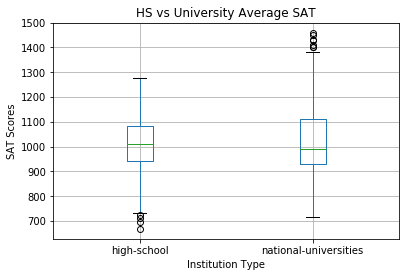

In [5]:
##----------------Plot the different average SAT scores of high schools in MA vs Universities----------------
#Plot average SAT scores 1 line is high school and 1 line is university
#export the sat-avg and School Type
SATforType=result[['sat-avg','schoolType']].copy()

#categorize school type
SATforType['schoolType']=SATforType['schoolType'].astype("category")

#Sample about 100 data points
SATforType=SATforType.sample(n=300)

#plot based on school type
SATforType.boxplot(by='schoolType')

#Format graph
plt.title("HS vs University Average SAT")
plt.suptitle("")
plt.ylabel("SAT Scores")
plt.xlabel("Institution Type")

### SAT for MA high school vs MA universities

#### Setup
For setup, SAT scores, school type and residing state are needed. Using state, I consider only institutions in MA. Furthermore, data is separated between high schools and universities. Now, I reposition the data set such that two columns consist of high school or university SAT average. This allows for better plotting. Lastly, after filtering data, a vast difference exists between the number of data available where 321 rows for high schools versus 16 rows for universities. To alleviate this vast difference, I sampled 209 out of 321 data points from the high school set based on the calculator used on the previous graph sampling for 95% accuracy and interval of 4 (https://www.surveysystem.com/sscalc.htm#one).

#### Analysis
In contrast to the previous graph, high schools are performing less optimally compared to universities in only MA. The 25-75th percentile scores representing high schools partially overlap the lower scores of universities. Furthermore, a large portion of scores lower than the lowest university range exist in high school data. A majority of these scores are recorded as anomalies, but these scores form a cluster.

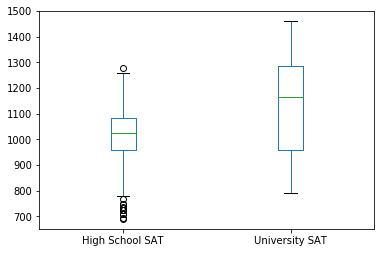

In [6]:
##----------------Plot the different average SAT scores of MA high schools in MA universities----------------
#Copy dataframe consisting of only avg SAT scores, school type and state
SATMA=result[['sat-avg','schoolType','State']].copy()

#Ensure only viewing institutions in MA
SATMA=SATMA.loc[SATMA['State']=='MA']

#Sepearate high schools from universities
HSSAT=SATMA.loc[SATMA['schoolType'] == 'high-school'].copy()
USAT=SATMA.loc[SATMA['schoolType'] == 'national-universities'].copy()

#Create new Dataframe as High School and University are separated with average SAT for easy plotting
SATforType=pd.DataFrame(data={'High School SAT':HSSAT['sat-avg'], 'University SAT':USAT['sat-avg']})

#Sample SAT from high schools as high schools contain 321 values as only 16 values of universities exist in MA.
SATforType['High School SAT']=SATforType['High School SAT'].sample(n=209)
SATforType.plot.box()


### MA high school Accountability and Assistance Level scores vs MA university SAT scores

#### Setup
Due to plotting based on high school ranking with SAT and university SAT with high school accountability and assistance level, more data manipulation is required than the previous two graphs. First, only universities in MA are evaluated. Second, since account/assis levels are created for high schools, in order to distinguish between levels of high schools and universities, the columns is labelled as 'University' for universities. Lastly, a lot of data exist for L1-L3 ranked schools in contrast to L4 and MA universities. Due to this, I sample various data points from L1 and L2 to alleviate this large offset (Again, using the calculator). I chose to separate based on level for better sample quality. This requires paritioning the data on the different level types, sampling, and merging. 

#### Analysis
It is apparent levels of schools present a difference in SAT scores. From level 1 to level 4, the decrease is consistent in SAT scores. Viewing level 4, the lowest ranks shows high schools lacking in education. This problem represents itself in reported SAT scores. The score range does not overlap with the university range except one reported score. This is seen as an anomaly in the box plot. Viewing layer 3, this overlaps with the 25th-75th percentile of MA universities; however, the median is about 200 points lower than the universities'. This is similar for layer 2 as well, but as stated before, a slight increase exists. Lastly, layer 1 is seen as the better schools in MA thus providing a good education to students. Sadly enough, all medians of high schools are lower than the median SAT scores for universities even high schools seens at level 1. 


Text(0.5,0,'Levels of Institutions')

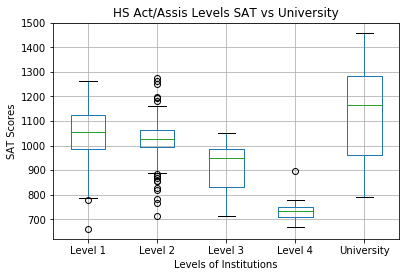

In [7]:
##----------------Plot PPI vs SAT----------------
#Copy dataframe consisting of only avg SAT scores, school type and state
SATMA=result[['sat-avg','schoolType','State', 'Accountability and Assistance Level']].copy()

#Ensure only viewing institutions in MA
SATMA=SATMA.loc[SATMA['State']=='MA']

#Set all universities Account/Assis level to 'University' for easy plotting
SATMA['Accountability and Assistance Level'] = np.where(SATMA['schoolType']=='national-universities','University',SATMA['Accountability and Assistance Level'])

#Categorize the account/assis level for plotting
SATMA['Accountability and Assistance Level']=SATMA['Accountability and Assistance Level'].astype("category")

#Separate the different levels due to difference in amount of data then sample level 1, level 2 and level 3 to provide better sample
#HS Level 1 =109 rows
#HS L2=149 rows 
#HS L3=59 rows
#HS L4=8 rows
#Univ=16 rows

HSL1=SATMA.loc[SATMA['Accountability and Assistance Level'] == 'Level 1'].copy().sample(92)
HSL2=SATMA.loc[SATMA['Accountability and Assistance Level'] == 'Level 2'].copy().sample(129)
HSL3=SATMA.loc[SATMA['Accountability and Assistance Level'] == 'Level 3'].copy().sample(54)
HSL4=SATMA.loc[SATMA['Accountability and Assistance Level'] == 'Level 4'].copy()
Univ=SATMA.loc[SATMA['Accountability and Assistance Level'] == 'University'].copy()

#Remerge the dataset
HSL1=pd.concat([HSL1,HSL2],axis=0,sort=False )
HSL1=pd.concat([HSL1,HSL3],axis=0,sort=False )
HSL1=pd.concat([HSL1,HSL4],axis=0,sort=False )
HSL1=pd.concat([HSL1,Univ],axis=0,sort=False )



#Plot the results
HSL1.boxplot(by='Accountability and Assistance Level')

#Format graph
plt.title("HS Act/Assis Levels SAT vs University")
plt.suptitle("")
plt.ylabel("SAT Scores")
plt.xlabel("Levels of Institutions")

## Summary

Based on the SAT provided by high schools and universities, high schools are on par with universities throughout the nation, but slightly unpar with universities in Massachusettes. Comparing high schools to national universities, the medians greatly overlap. Unfortunately the schools consistently score lower than the median of universities in Massachusettes. Furthermore, the levels of accountability and assistance assigned do correlate with SAT scores such that lower median scores are ranked lower. Even with the highest high school level, the schools perform about average for universities. 

#### Limitations
Even with the findings, the national-universities data set does not represent all possible and accredited universities in the United States. Massachusettes does not contain only 16 universities (https://www.usnews.com/best-colleges/ma). With a quick search in US News, 76 universities are listed.